In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv("data_raw/full_post_list.csv", index_col=0)
sort = df[["verdict", "title"]].groupby("verdict").count()
sort = sort.sort_values(by=["title"], ascending=False).reset_index()
sort = sort[sort["title"] > 2]
print(sort["verdict"].tolist())

['Not the A-hole', 'Asshole', 'No A-holes here', 'Everyone Sucks', 'not the a-hole', 'Not enough info', 'asshole', 'Update', 'META', 'UPDATE', 'no a--holes here', 'everyone sucks', 'Shitpost']


In [3]:
def pp_mapverdict(df):
    df = pd.read_csv("data_raw/full_post_list.csv", index_col=0)
    df["target"] = df["verdict"].map(
        lambda y: "NTA"
        if y in ["Not the A-hole", "not the a-hole"]
        else "YTA"
        if y in ["Asshole", "asshole"]
        else "NAH"
        if y in ["No A-holes here", "no a--holes here"]
        else "ESH"
        if y in ["Everyone Sucks", "everyone sucks"]
        else "n/a"
    )
    df = df[df["target"] != "n/a"]
    return df

df = pp_mapverdict(df)
df[["target", "title"]].groupby("target").count()

,title
target,
ESH,881
NAH,1697
NTA,10490
YTA,3439


In [4]:
def pp_minbodylength(df):
    length_body = []
    for text in df["body"]:
        length = len(str(text))
        length_body.append(length)
    df["length_body"] = length_body
    df = df[(df["length_body"] >= 15) & (df["length_body"] <= 3500)]
    return df

df = pp_minbodylength(df)
df.sort_values(by=["length_body"]).head()

,title,id,score,num_comments,body,date,verdict,target,length_body
17930,AITA For being upset because my wife won’t let...,b9xb5n,178,143,Basically title. \n\n,2019-04-05 22:03:48,Not the A-hole,NTA,19
19881,AITA for photoshopping the hair of one of my w...,awzuvd,319,250,Over 600 pics...it was fun. 🤦🏻‍♂️,2019-03-03 23:07:32,Not the A-hole,NTA,33
18625,WIBTA for taking a family members child to get...,b5oau9,224,180,Throw away account for obvious reasons \n\n,2019-03-26 11:03:17,Everyone Sucks,ESH,41
20896,AITA for not answering my phone to numbers I d...,8nszxn,128,47,I refuse to call back if they don't leave a me...,2018-06-01 15:55:15,not the a-hole,NTA,98
19332,AITA for wanting to order delivery in a blizzard,b11xp9,81,94,"I didn't, but only because my friends convince...",2019-03-14 15:51:55,Not the A-hole,NTA,113


In [5]:
def pp_titlecheck(df):
    type_list = []
    for aita in df["title"]:
        title_aita = list(aita.split(" "))[0]
        title_aita = (" ".join(re.findall("[a-zA-Z]+", title_aita))).lower()

        aita_check = bool(re.match(title_aita, "aita"))
        wibta_check = bool(re.match(title_aita, "wibta"))

        if aita_check:
            type_list.append("AITA")
        elif wibta_check:
            type_list.append("WIBTA")
        else:
            type_list.append("n/a")

    df["title_aita"] = type_list
    df = df[df["title_aita"] != "n/a"]
    return df

df = pp_titlecheck(df)
df[["title_aita", "title"]].groupby("title_aita").count()

,title
title_aita,
AITA,13878
WIBTA,2512


In [12]:
def pp_endcode_text(df):
    text_list = []
    for text in df["body"]:
        text = text.replace('\n', ' ').replace('\r', '').replace('’', '\'')
        goodtext = text.encode('cp1252', 'ignore')
        goodtext = goodtext.decode('utf-8')
        text_list.append(goodtext)
    df["body"] = text_list 
    return df

df = pp_endcode_text(df)

In [11]:
aita = pd.read_csv("data_raw/full_post_list.csv", index_col=0)

def pp_full(df):
    df = pp_mapverdict(df)
    df = pp_minbodylength(df)
    df = pp_titlecheck(df)
    df = df.reset_index(drop=True)
    return df

aita = pp_full(aita)
aita.head()

,title,id,score,num_comments,body,date,verdict,target,length_body,title_aita
0,AITA for calling my ex out on his fb post?,freddt,118,1542,"So little baby ""*J*"" was born 16/5/17, his dad...",2020-03-29 22:08:12,Not the A-hole,NTA,1515,AITA
1,AITA for uninviting my brother from my wedding...,evcp7o,65,1406,"Hi everyone, I'm using a throwaway, and I just...",2020-01-28 22:17:02,Not the A-hole,NTA,2476,AITA
2,AITA for finally poking back at my childfree s...,evbyg8,131,1844,"My wife's sister Abby is ""childfree."" Neither...",2020-01-28 21:28:47,Not the A-hole,NTA,1711,AITA
3,"AItA for refusing my MIL's offer of ""free"" chi...",ekc023,76,2387,Throwaway due to the specificity of the detail...,2020-01-05 11:41:55,Not the A-hole,NTA,1184,AITA
4,AITA MIL tried to have my baby blessed without...,ek8tg4,98,483,My MIL and FIL are first time grandparents who...,2020-01-05 05:40:01,Not the A-hole,NTA,2272,AITA


In [8]:
df2 = aita.copy()

def density_plot_var_target(variables, target, df2):
    count = 0
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    for variable in variables:
        if variable != "length_body":
            df2[variable] = np.log(df2[variable])
        for name in list(df2[target].unique()):
            g=sns.kdeplot(
                df2[variable][(df2[target] == name)],
                legend=True,
                shade=True,
                ax=ax[count]
            )
        if variable != "length_body":
            g.title.set_text(("log %s"%variable))
        else:
            g.title.set_text(variable)
        g.set_xlim(left=0)
        g.legend(list(df2[target].unique()))
        count += 1

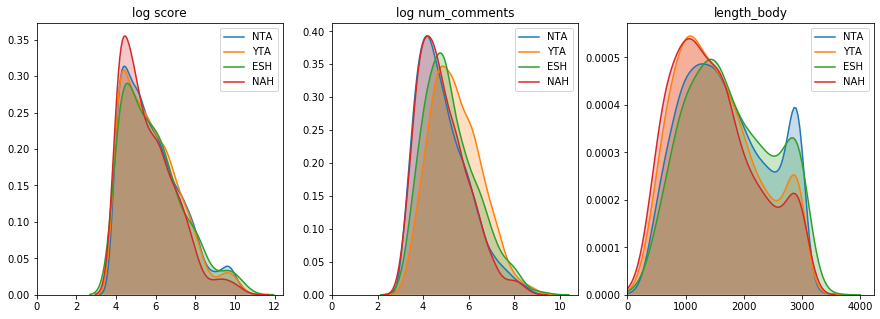

In [9]:
density_plot_var_target(["score", "num_comments", "length_body"], "target", df2)

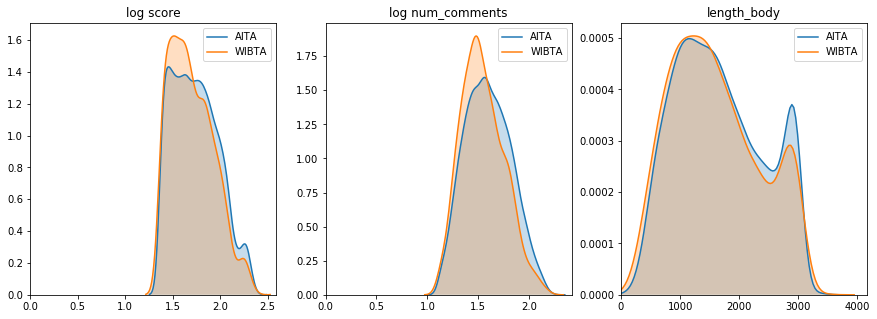

In [10]:
density_plot_var_target(["score", "num_comments", "length_body"], "title_aita", df2)